# Initializing and Preprocessing
Load up experiment & annotations

In [2]:
#import sys
#sys.path.append("/tmp/pycharm_project_XXX/")
#sys.path.append("/tmp/pycharm_project_XXX/src/")

%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from preprocessing._chunk_preparation import preprocess_chunks_for_multiclass_test, preprocess_chunks_for_null_test, concat_chunks_for_feature_extraction
from preprocessing._segmentation import segment_null_classification, segment_windows
from visualization._visualization import swarm_plot_top_features

from classification.classification import classify_all
from data_reading.phyphox import read_experiments_in_dir
from features import extract_timeseries_features
from file_handling import get_sub_directories
from visualization import plot_duration_histogram
from tsfresh.feature_extraction.settings import MinimalFCParameters, ComprehensiveFCParameters, EfficientFCParameters

sample_rate = 50

ImportError: cannot import name 'preprocess_chunks_for_null_test_with_indoorpreprocess_chunks_for_multiclass_test' from 'preprocessing._chunk_preparation' (/Users/julio/Documents/Uni/5_Master/Master Project/mp-mental-health-2020/src/preprocessing/_chunk_preparation.py)

In [2]:
# config:

experiment_dir_path = "../../data/phyphox/full recordings/"
experiment_dirs = get_sub_directories(experiment_dir_path)
use_indoor = True
window_size = 50
# MinimalFCParameters, ComprehensiveFCParameters, EfficientFCParameters
feature_calculation_setting = MinimalFCParameters()

# Ana-2, Ariane, Julian, Wiki
experiment_dirs_selected = ["Ana-2","Ariane","Julian","Wiktoria"]
experiment_dirs = [exp_dir for exp_dir in experiment_dirs if exp_dir.split("/")[-1] in experiment_dirs_selected]


Preprocess data

In [3]:
chunks, null_chunks, y = read_experiments_in_dir(experiment_dirs, sample_rate, drop_lin_acc=True)

In [14]:
plot_duration_histogram(chunks["right"])
plot_duration_histogram(null_chunks["right"])

# append the action id to the dataframe
# we need to do this to be able to extract time series features later
# Preprocess data

"""
if use_indoor:
    chunks_ocd, chunks_null_class = preprocess_chunks_for_null_test_with_indoor(chunks, null_chunks)
else:
    chunks_ocd, chunks_null_class = preprocess_chunks_for_null_test(chunks, null_chunks)
"""

if use_indoor:
    chunks_ocd, chunks_null_class = preprocess_chunks_for_multiclass_test(chunks, null_chunks, y)

In [6]:
window_size

### Segmentation

In [5]:
labels = y.loc[:, "label"].squeeze()


# prepare null chunks
chunks_ocd_segmented, labels_ocd_segmented, chunks_null_segmented, labels_null_segmented = segment_null_classification(chunks_ocd, chunks_null_class, window_size)

null_classification_df, labels_null_classification = concat_chunks_for_feature_extraction(
        [chunks_ocd_segmented, chunks_null_segmented],
        [labels_ocd_segmented, labels_null_segmented])
assert len(set(labels_null_classification)) == 2

## Binary Classification: OCD activities vs null class samples
### Feature extraction for OCD activities vs non-OCD activities

In [43]:

X_null_class_classification = extract_timeseries_features(null_classification_df, use_indoor=use_indoor, feature_set_config=feature_calculation_setting)

Feature Extraction: 100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


### Feature selection

In [44]:

impute(X_null_class_classification)
X_null_classification_selected = select_features(X_null_class_classification, labels_null_classification)

In [45]:
scaler = StandardScaler()
X_null_classification = scaler.fit_transform(X_null_classification_selected)

In [ ]:
labels_null_classification.values

### Train models and score results

In [46]:
print("Binary classification")
classify_all(X_null_classification, labels_null_classification)

Binary classification
Logistic Regression: 0.58 +/- 0.10
LDA: 0.58 +/- 0.10
LinearSVC: 0.58 +/- 0.09
CART: 0.46 +/- 0.09
Random Forest: 0.45 +/- 0.11
NB: 0.55 +/- 0.06


/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/p

KeyboardInterrupt: 

In [ ]:
labels_null_classification.reset_index(drop=True)
labels_null_classification

Process ForkPoolWorker-53:
Process ForkPoolWorker-56:
Process ForkPoolWorker-54:
Process ForkPoolWorker-52:
Process ForkPoolWorker-51:
Process ForkPoolWorker-49:
Process ForkPoolWorker-55:
Process ForkPoolWorker-50:
Traceback (most recent call last):
Traceback (most recent call last):


   index         class                      features     value
0      0  OCD activity  acceleration z_right__median  0.786816
1      1  OCD activity  acceleration z_right__median  0.708061
2      2  OCD activity  acceleration z_right__median  0.706495
3      3  OCD activity  acceleration z_right__median  0.685359
4      4  OCD activity  acceleration z_right__median  0.126383


KeyboardInterrupt: 

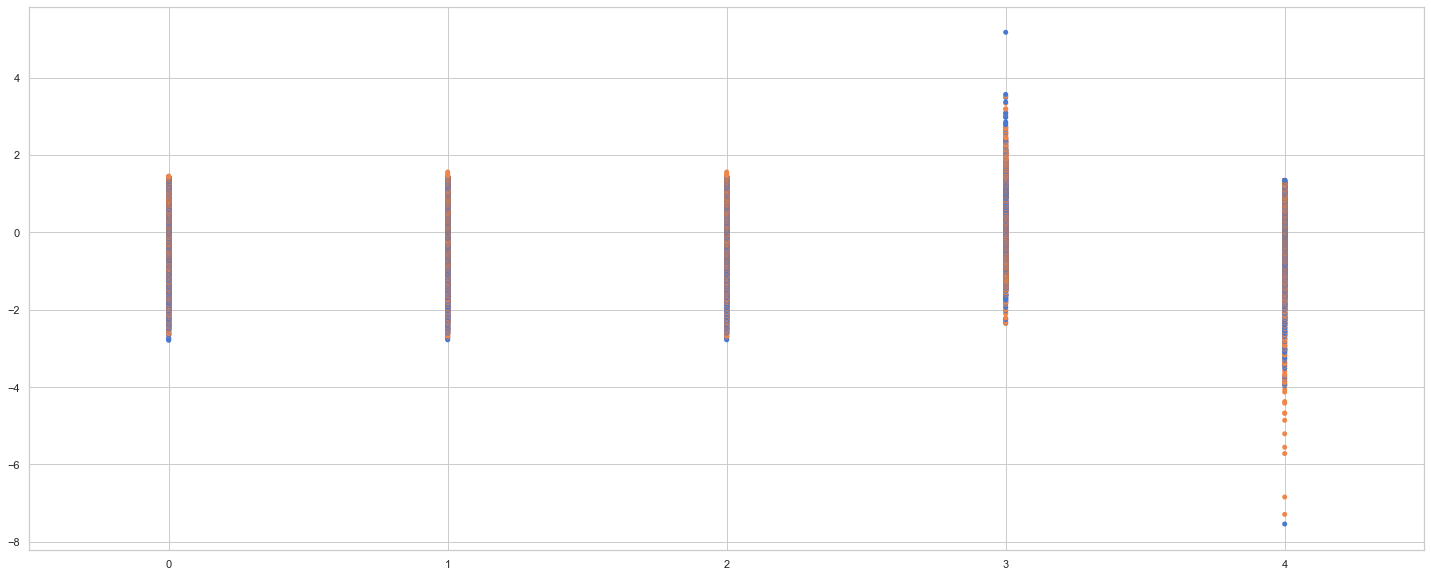

In [47]:
# add the old labels to the column names of the features again
X_null_classification_selected = pd.DataFrame(X_null_classification, columns=X_null_classification_selected.columns)

# reduce the amount of selected features and append the labels as an extra column
X_y = pd.concat([X_null_classification_selected.iloc[:,:5], labels_null_classification.reset_index(drop=True)], axis=1)

label_vals = { 11: "null class", 12: "OCD activity"}
# rename the last column
cols = [c for c in X_y.columns]
cols[-1] = "class"
X_y.columns = cols
X_y.replace({"class":label_vals}, inplace=True)

swarm_plot_top_features(pd.DataFrame(X_y).reset_index())


# Multiclass classification

For the multi class classification we can reuse
- data loading
- preprocessing
- segmentation

We mainly need to:
- re label the OCD segments with the y array
- do the segmentation for the ocd chunks again
- extract features again
- select and scale features again
- classify again
- visualize results again

In [48]:
# make sure we already run the segmentation for the binary classification earlier

assert len(labels_null_segmented) != 0

labels_ocd_multiclass = labels.reset_index(drop=True)
_, labels_ocd_segmented_multiclass = segment_windows(chunks_ocd, labels_ocd_multiclass.to_numpy(), window_size)

assert len(set(labels_ocd_multiclass)) == len(set(labels_ocd_segmented_multiclass))

/Users/julio/Documents/Uni/5_Master/Master Project/mp-mental-health-2020/src/preprocessing/_segmentation.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_new["action_id"] = [(action_id, i)] * len(c_new)


In [66]:
# reuse chunks_ocd_segmented from the segmentation for the binary classifier
assert len(labels_ocd_segmented_multiclass) == len(chunks_ocd_segmented)

# with null class
mulit_class_df, labels_multi_class_classification = concat_chunks_for_feature_extraction(
        [chunks_ocd_segmented, chunks_null_segmented],
        [labels_ocd_segmented_multiclass, labels_null_segmented])

# without null class
"""
mulit_class_df, labels_multi_class_classification = concat_chunks_for_feature_extraction(
        [chunks_ocd_segmented],
        [labels_ocd_segmented_multiclass])
"""
assert len(set(labels_multi_class_classification)) == len(set(labels_ocd_segmented_multiclass)) + 1

In [79]:
labels_multi_class_classification = labels_multi_class_classification.str.replace("  ", " ").str.strip()

assert set(labels_multi_class_classification) == {'checking oven',
 'cleaning cup',
 'cleaning floor',
 'cleaning leg',
 'cleaning table',
 'cleaning window',
 'drying hands',
 'null class',
 'pulling door',
 'pulling hair',
 'pushing door',
 'sitting down',
 'standing up',
 'walking',
 'washing hands'}

### Feature extraction for multi class OCD activities incl null

In [135]:
X_multi_class_classification = extract_timeseries_features(mulit_class_df, use_indoor=True, feature_set_config=feature_calculation_setting)

Feature Extraction: 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


### Feature selection for multi class OCD activities incl null

In [136]:
X_multi_class_classification.head()

,acceleration x__length,acceleration x__maximum,acceleration x__mean,acceleration x__median,acceleration x__minimum,acceleration x__standard_deviation,acceleration x__sum_values,acceleration x__variance,acceleration x_right__length,acceleration x_right__maximum,...,gyroscope z__variance,gyroscope z_right__length,gyroscope z_right__maximum,gyroscope z_right__mean,gyroscope z_right__median,gyroscope z_right__minimum,gyroscope z_right__standard_deviation,gyroscope z_right__sum_values,gyroscope z_right__variance,minor
id,,,,,,,,,,,,,,,,,,,,,
"(0, 0)",50.0,-0.631106,-3.997421,-2.653395,-11.559566,3.216081,-199.871045,10.343175,50.0,5.480186,...,3.441975,50.0,0.136636,-0.016842,0.020151,-0.341074,0.119880,-0.842110,0.014371,6.0
"(0, 1)",50.0,-1.247350,-2.991439,-3.068343,-4.022254,0.539948,-149.571939,0.291544,50.0,5.703636,...,0.007371,50.0,0.101273,-0.027945,-0.023452,-0.125392,0.054400,-1.397258,0.002959,6.0
"(0, 2)",50.0,-2.028761,-2.898846,-2.904659,-4.207396,0.456619,-144.942311,0.208501,50.0,5.574845,...,0.006744,50.0,0.127797,0.037967,0.039080,-0.084738,0.053090,1.898340,0.002819,5.0
"(0, 3)",50.0,-3.032735,-3.690309,-3.685505,-4.297477,0.317166,-184.515453,0.100595,50.0,5.617421,...,0.012308,50.0,0.122563,-0.058320,-0.059413,-0.191839,0.090519,-2.916007,0.008194,6.0
"(1, 0)",50.0,-0.212954,-2.158478,-2.251022,-2.941579,0.669639,-107.923879,0.448416,50.0,10.154037,...,0.448926,50.0,0.505471,0.224282,0.158280,-0.020072,0.129011,11.214085,0.016644,6.0


In [ ]:
impute(X_multi_class_classification)
X_multi_class_classification_selected = select_features(X_multi_class_classification, labels_multi_class_classification)


In [90]:
scaler = StandardScaler()
X_multi_class_classification_scaled = scaler.fit_transform(X_multi_class_classification_selected)

In [ ]:
from visualization._visualization import pca_2d, sne_2d
pca_2d(X_multi_class_classification_scaled, labels_multi_class_classification, labels_multi_class_classification.unique()[0:16], ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','C15','C16','C17','C18'])

In [ ]:
sne_2d(X_multi_class_classification_scaled, labels_multi_class_classification, labels_multi_class_classification.unique(), ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14','C15','C16','C17','C18'])

### Train models and score results

In [126]:
set(labels_multi_class_classification)

{'checking oven',
 'cleaning cup',
 'cleaning floor',
 'cleaning leg',
 'cleaning table',
 'cleaning window',
 'drying hands',
 'null class',
 'pulling door',
 'pulling hair',
 'pushing door',
 'sitting down',
 'standing up',
 'walking',
 'washing hands'}

Multi class classification: using indoor: False; FC params: MinimalFCParameters; window_size 50
Logistic Regression: 0.61 +/- 0.03
['null class' 'null class' 'null class' ... 'cleaning window' 'null class'
 'null class']
LDA: 0.57 +/- 0.05
['null class' 'null class' 'null class' ... 'cleaning window' 'null class'
 'null class']
LinearSVC: 0.60 +/- 0.03
['null class' 'null class' 'null class' ... 'cleaning window' 'null class'
 'null class']
CART: 0.50 +/- 0.04
['null class' 'null class' 'null class' ... 'cleaning window'
 'cleaning table' 'cleaning table']
Random Forest: 0.56 +/- 0.08
['null class' 'null class' 'null class' ... 'cleaning window' 'null class'
 'null class']
NB: 0.26 +/- 0.02
['walking' 'cleaning floor' 'cleaning floor' ... 'cleaning window'
 'pulling door' 'pulling door']
SVC: 0.60 +/- 0.05
['null class' 'null class' 'null class' ... 'null class' 'null class'
 'null class']


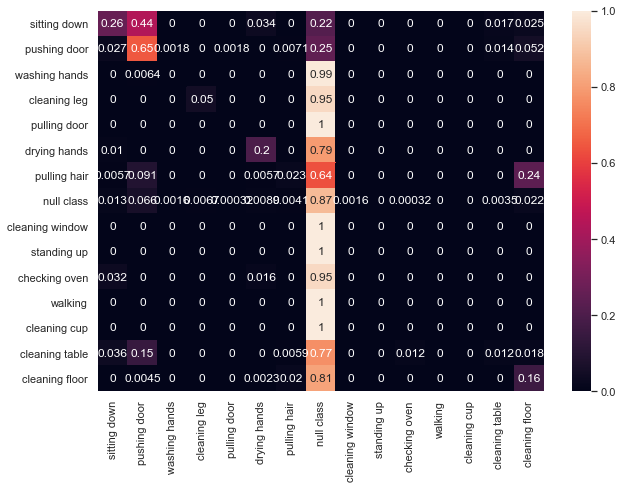

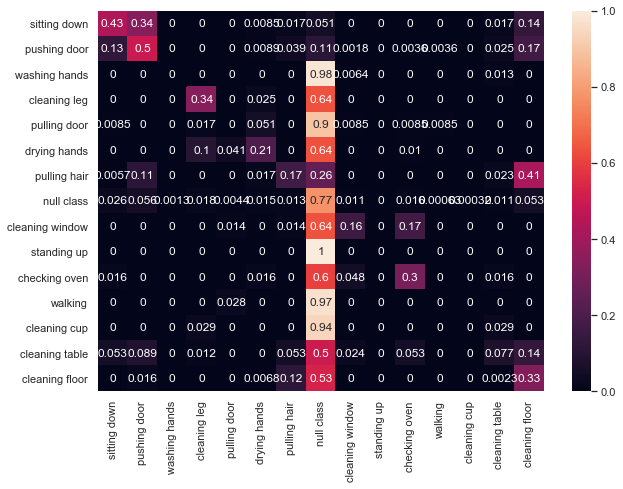

/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/p

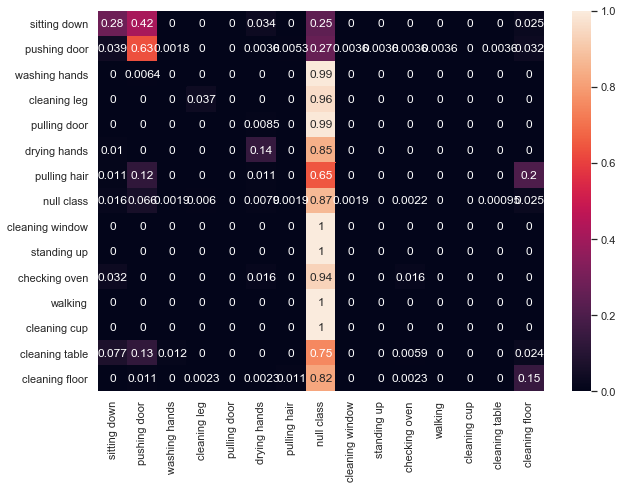

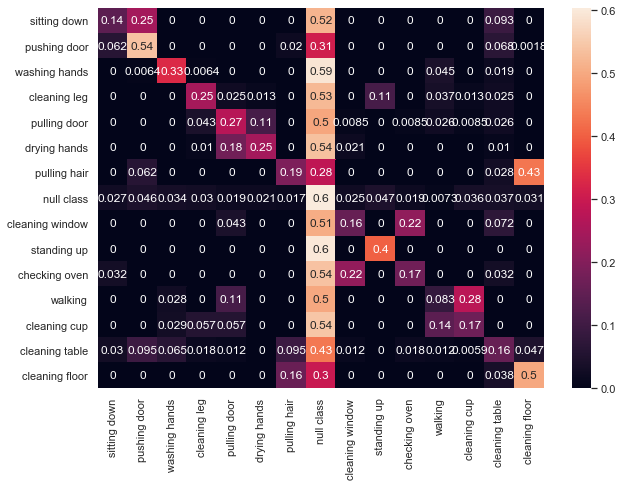

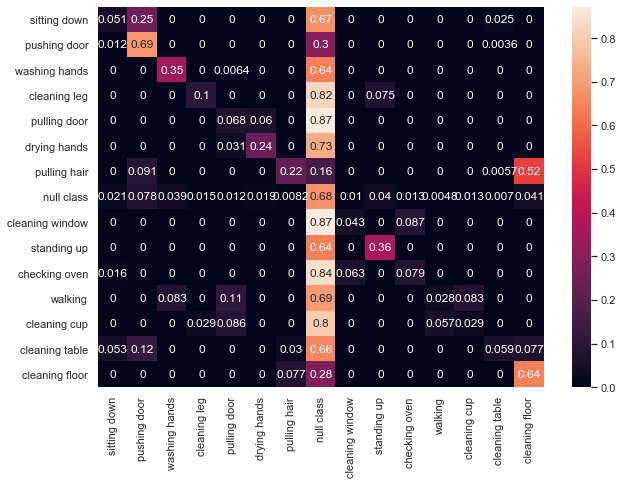

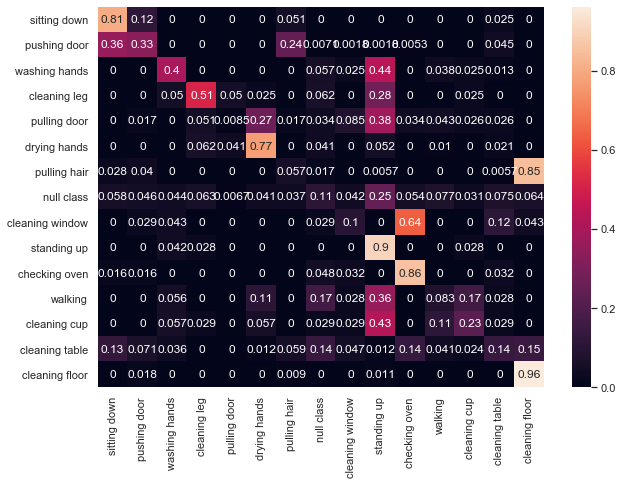

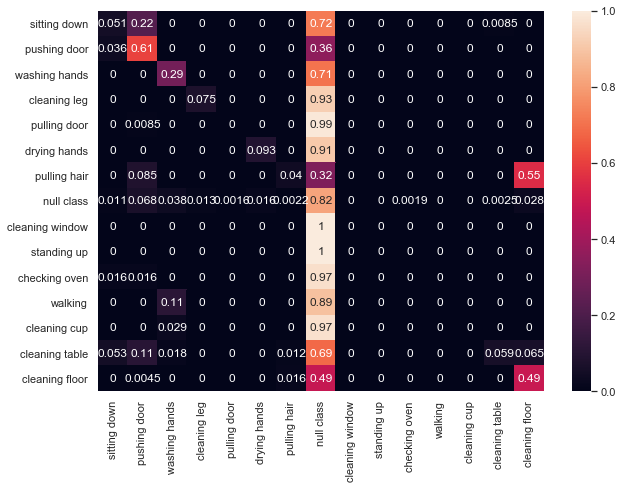

In [128]:
print("Multi class classification: using indoor: {}; FC params: {}; window_size {}".format(use_indoor,feature_calculation_setting.__class__.__name__, window_size))
classify_all(X_multi_class_classification_scaled, labels_multi_class_classification)


print("Multi class classification with null class")
classify_all(X_multi_class_classification_scaled, labels_multi_class_classification)

In [85]:
set(labels_multi_class_classification)

{'checking oven',
 'cleaning cup',
 'cleaning floor',
 'cleaning leg',
 'cleaning table',
 'cleaning window',
 'drying hands',
 'null class',
 'pulling door',
 'pulling hair',
 'pushing door',
 'sitting down',
 'standing up',
 'walking',
 'washing hands'}

In [91]:
print("Multi class classification with null class")
classify_all(X_multi_class_classification_scaled, labels_multi_class_classification)

Multi class classification with null class
Logistic Regression: 0.61 +/- 0.03
LDA: 0.57 +/- 0.05
LinearSVC: 0.60 +/- 0.03
CART: 0.51 +/- 0.05
Random Forest: 0.56 +/- 0.08
NB: 0.26 +/- 0.02
SVC: 0.60 +/- 0.05


/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/julio/opt/anaconda3/envs/master-project/lib/p